In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from tensorflow.keras import layers, models

In [2]:
# Function to load images from folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

In [3]:
# Define paths for different categories
consonant_path = '../nepali_characters_dataset/consonants/'
numeral_path = '../nepali_characters_dataset/numerals/'
vowel_path = '../nepali_characters_dataset/vowels/'

In [4]:
# Load data for consonants
consonant_data = [load_images_from_folder(consonant_path + str(i)) for i in range(1, 37)]
# Load data for numerals
numeral_data = [load_images_from_folder(numeral_path + str(i)) for i in range(10)]
# Load data for vowels
vowel_data = [load_images_from_folder(vowel_path + str(i)) for i in range(1, 13)]


In [5]:
# Combine data from all categories
combined_data = consonant_data + numeral_data + vowel_data

In [6]:
total_samples = sum(len(data) for data in combined_data)
print("Total number of samples:", total_samples)


Total number of samples: 91112


In [7]:
# Preprocess data with edge detection and feature extraction
def preprocess_data(data, max_features=144):    # hog features of train dataset is 144
    processed_data = []
    for images in data:
        for img in images:
            # Apply edge detection
            edges = cv2.Canny(img, 100, 200)
            # Extract HOG features
            hog_features = hog(edges, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
            # Ensure all feature vectors have the same length
            if len(hog_features) < max_features:
                hog_features = np.pad(hog_features, (0, max_features - len(hog_features)))
            elif len(hog_features) > max_features:
                hog_features = hog_features[:max_features]
            processed_data.append(hog_features)
    return np.array(processed_data)

In [8]:
# Load and preprocess data
X = preprocess_data(combined_data)

In [9]:
# Generate labels for each category
y = np.concatenate([np.full(len(data), i) for i, data in enumerate(combined_data)])

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Define image dimensions and number of classes
img_height, img_width = 32, 32
num_classes = 36 + 10 + 12  # Total number of classes

In [12]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Build the model
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [14]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               18560     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 58)                3770      
                                                                 
Total params: 30586 (119.48 KB)
Trainable params: 30586 (119.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=20, validation_data=(X_test_scaled, y_test))

Epoch 1/20


2278/2278 [==============================] - 9s 3ms/step - loss: 1.7816 - accuracy: 0.4964 - val_loss: 1.3923 - val_accuracy: 0.5839
Epoch 2/20
2278/2278 [==============================] - 6s 3ms/step - loss: 1.2810 - accuracy: 0.6137 - val_loss: 1.2675 - val_accuracy: 0.6174
Epoch 3/20
2278/2278 [==============================] - 6s 3ms/step - loss: 1.1691 - accuracy: 0.6442 - val_loss: 1.2116 - val_accuracy: 0.6357
Epoch 4/20
2278/2278 [==============================] - 7s 3ms/step - loss: 1.1020 - accuracy: 0.6615 - val_loss: 1.1683 - val_accuracy: 0.6418
Epoch 5/20
2278/2278 [==============================] - 6s 3ms/step - loss: 1.0552 - accuracy: 0.6757 - val_loss: 1.1420 - val_accuracy: 0.6565
Epoch 6/20
2278/2278 [==============================] - 7s 3ms/step - loss: 1.0205 - accuracy: 0.6851 - val_loss: 1.1415 - val_accuracy: 0.6546
Epoch 7/20
2278/2278 [==============================] - 6s 3ms/step - loss: 0.9930 - accuracy: 0.6942 - val_loss: 1.1260 - val_accurac

In [28]:
# Evaluate the model and print metrics
model.evaluate(X_test_scaled, y_test)
print('Training Loss:', history.history['loss'][-1], 
      '\nValidation Loss:', history.history['val_loss'][-1], 
      '\nTraining Accuracy:', history.history['accuracy'][-1], 
      '\nValidation Accuracy:', history.history['val_accuracy'][-1])

570/570 [==============================] - 1s 2ms/step - loss: 1.1136 - accuracy: 0.6739
Training Loss: 0.8335440158843994 
Validation Loss: 1.1136232614517212 
Training Accuracy: 0.7378891110420227 
Validation Accuracy: 0.6739285588264465


In [18]:
# Save the model
model.save('recognition_model_canny_edge.keras')

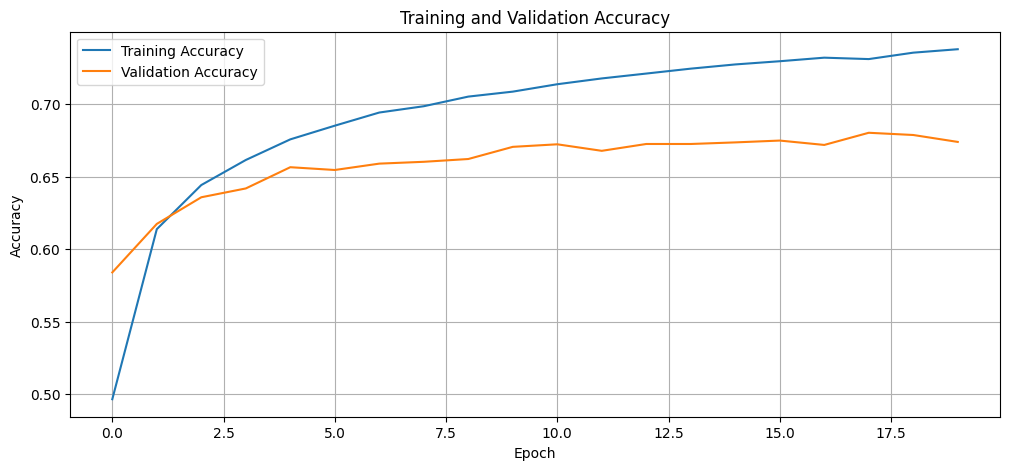

In [19]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

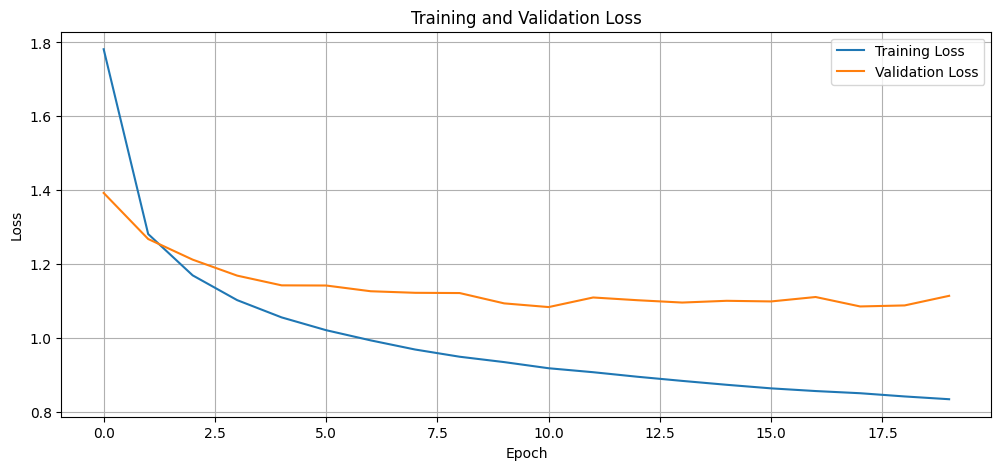

In [20]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()